# Simulating biophysically detailed multi-compartmental models using ISF

This notebook guides the user on how to use ISF to run *in silico* current injection experiments using biophysically detailed full-compartmental models using the [`Simulator`](../../../biophysics_fitting/simulator.py) and [`Evaluator`](../../../biophysics_fitting/evaluator.py) objects. These objects can be configured once per cell, and re-used for various simulation protocols.

[Tutorial 1.2](./1.2%20Evaluation.ipynb) will show how to evaluate existing biophysically detailed compartmental models

[Tutorial 1.3](./1.3%20Generation.ipynb) will use the concepts outlined in this Tutorial and [Tutorial 1.2](./1.2%20Evaluation.ipynb) to generate biophysically detailed compartmental models that satisfy the empirical constraints outlined in [Tutorial 1.2](./1.2%20Evaluation.ipynb).

Adapt your desired output path below. Here, the results of the tutorials will be saved.

In [1]:
from pathlib import Path
tutorial_output_dir = f"{Path.home()}/isf_tutorial_output"  # <-- Change this to your desired output directory

In [2]:
%matplotlib inline
import Interface as I
db = I.DataBase(tutorial_output_dir).create_sub_db("neuron_modeling")

[INFO] ISF: Current version: heads/data+0.g1077bcf8.dirty
[INFO] ISF: Current pid: 227340


--No graphics will be displayed.


[INFO] ISF: Loading mechanisms:
[ATTENTION] ISF: The source folder has uncommited changes!



[INFO] ISF: Loaded modules with __version__ attribute are:
IPython: 8.12.2, Interface: heads/data+0.g1077bcf8.dirty, PIL: 10.4.0, _brotli: 1.0.9, _csv: 1.0, _ctypes: 1.1.0, _curses: b'2.2', _decimal: 1.70, argparse: 1.1, backcall: 0.2.0, blosc: 1.11.1, bluepyopt: 1.9.126, brotli: 1.0.9, certifi: 2024.08.30, cffi: 1.17.0, charset_normalizer: 3.4.0, click: 7.1.2, cloudpickle: 3.1.0, colorama: 0.4.6, comm: 0.2.2, csv: 1.0, ctypes: 1.1.0, cycler: 0.12.1, cytoolz: 0.12.3, dash: 2.18.2, dask: 2.30.0, dateutil: 2.9.0, deap: 1.4, debugpy: 1.8.5, decimal: 1.70, decorator: 5.1.1, defusedxml: 0.7.1, distributed: 2.30.0, distutils: 3.8.20, django: 1.8.19, entrypoints: 0.4, executing: 2.1.0, fasteners: 0.17.3, flask: 1.1.4, fsspec: 2024.10.0, future: 1.0.0, greenlet: 3.1.1, idna: 3.10, ipaddress: 1.0, ipykernel: 6.29.5, ipywidgets: 8.1.5, isf_pandas_msgpack: 0.2.3, itsdangerous: 1.1.0, jedi: 0.19.1, jinja2

## Equipping a morphology with biophysical parameters

This section will introduce a format for biophysical parameters, and how to apply them to a cell morphology using the [`single_cell_parser`](../../../single_cell_parser/__init__.py) package. We will use the layer 5 Pyramidal Tract neuron as an example application.

Which format do these parameters need to have?

In [3]:
from getting_started import example_data_dir
import ast
import pprint

cell_param_file = I.os.path.join(
    example_data_dir,
    'biophysical_constraints',
    '86_C2_center.param')


with open(cell_param_file, 'r') as f:
    params = f.read()
pprint.pp(ast.literal_eval(params))

{'info': {'name': 'hay_2011_dend_test',
          'author': 'regger',
          'date': '15Oct2014'},
 'NMODL_mechanisms': {'channels': '/'},
 'mech_globals': {},
 'neuron': {'filename': '/gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/getting_started/example_data/anatomical_constraints/86_C2_center.hoc',
            'cell_modify_functions': {'scale_apical_morph_86': {}},
            'Soma': {'properties': {'Ra': 100.0,
                                    'cm': 1.0,
                                    'ions': {'ek': -85.0, 'ena': 50.0}},
                     'mechanisms': {'global': {},
                                    'range': {'pas': {'spatial': 'uniform',
                                                      'g': 3.26e-05,
                                                      'e': -90},
                                              'Ca_LVAst': {'spatial': 'uniform',
                                                           'gCa_LVAstbar': 0.00462},
           

The variable `cell_param` is one big dictionary-like object, including information on:

- the spatial distribution of ion channels
- $Ca^{2+}$ buffering dynamics
- default simulation parameters (time interval and resolution)
- recording site locations
- passive properties (capacitance, input resistance, and reversal potentials)
- a morphology file

Using these parameters, we can create a [`Cell`](../../../single_cell_parser/cell.py) object, containing all the information on morphology and simulation data in a Python wrapper. For our usecase, we need to pass an additional argument to scale the apical dendrite of the L5PT with. Why this is necessary is outlined [here](../auxiliary%20notebooks/A.1%20Morphology%20Reconstruction.ipynb)

In [4]:
from single_cell_parser.cell_modify_functions.scale_apical_morph_86 import scale_apical_morph_86
import neuron
h = neuron.h
I.logger.setLevel("INFO")  # verbose output to see what is happening

cell_param = I.scp.build_parameters(cell_param_file) # this is the main method to load in parameterfiles
cell = I.scp.create_cell(
    cell_param.neuron, 
    ) # this is the main method to create a cell

I.logger.setLevel("ATTENTION")

[INFO] single_cell_parser: -------------------------------
[INFO] single_cell_parser: Starting setup of cell model...
[INFO] single_cell_parser: Loading cell morphology...
[INFO] reader: Reading hoc file /gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/getting_started/example_data/anatomical_constraints/86_C2_center.hoc
[INFO] cell_parser: Creating AIS:
[INFO] cell_parser:     axon hillock diameter: 3.00
[INFO] cell_parser:     initial segment diameter: 1.75
[INFO] cell_parser:     myelin diameter: 1.00
[INFO] single_cell_parser: Setting up biophysical model...
[INFO] cell_parser:     Adding membrane properties to Soma
[INFO] cell_parser:     Adding membrane properties to Dendrite
[INFO] cell_parser:     Adding membrane properties to ApicalDendrite
[INFO] cell_parser:     Adding membrane properties to AIS
[INFO] cell_parser:     Adding membrane properties to Myelin
[INFO] cell_parser:     Setting up spatial discretization...
[INFO] cell_parser:     frequency used for 

We now have a biophysically detailed [`Cell`](../../../single_cell_parser/cell.py) object. Let's start by figuring out some general morphological properties of the example cell

In [5]:
length = sum([
    sec.L for sec in cell.sections])
dendrite_length = sum([
    sec.L for sec in cell.sections if sec.label in ['Soma', 'Dendrite', 'ApicalDendrite']])
soma_area = sum([
    sec.area for sec in cell.sections if sec.label == 'Soma'])
apic_area = sum([
    sec.area for sec in cell.sections if sec.label == 'ApicalDendrite'])

print('total length = {:.0f} micron'.format(length))
print('total dendritic length = {:.0f} micron'.format(dendrite_length))
print('soma area = {:.0f} micron^2'.format(soma_area))
print('apical dendrite area = {:.0f} micron^2'.format(apic_area))

total length = 16340 micron
total dendritic length = 15290 micron
soma area = 916 micron^2
apical dendrite area = 16855 micron^2


What does this morphology look like?

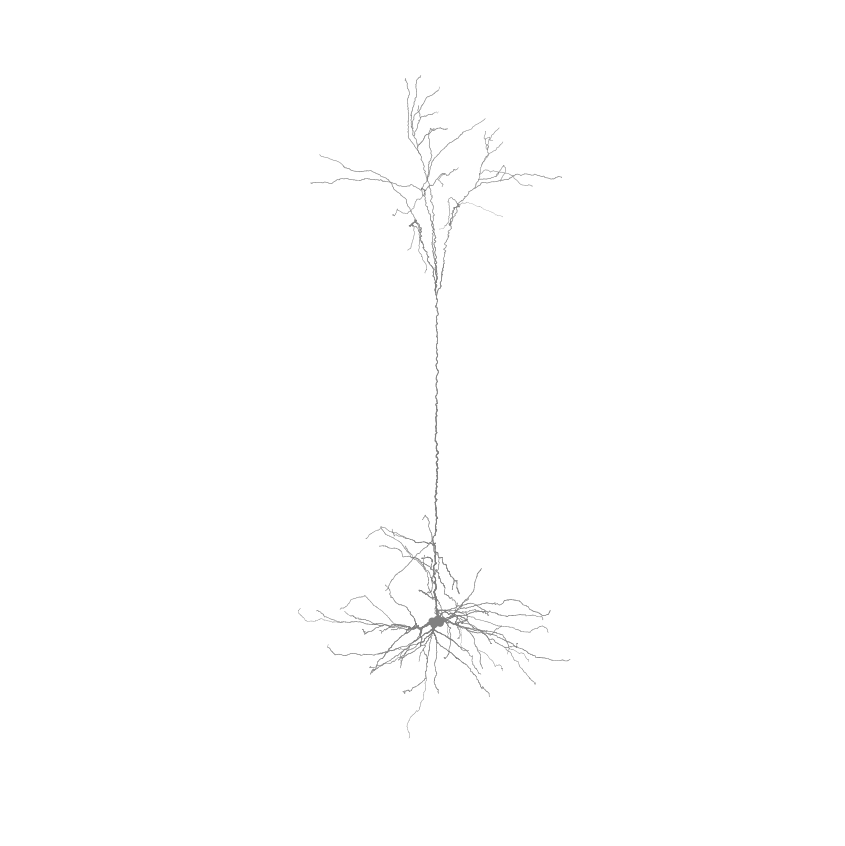

In [6]:
%matplotlib inline
from visualize.cell_morphology_visualizer import CellMorphologyVisualizer
fig = CellMorphologyVisualizer(cell).plot()

Or an interactive plot:

In [7]:
from visualize.cell_morphology_visualizer import CellMorphologyInteractiveVisualizer
cmiv = CellMorphologyInteractiveVisualizer(cell)
fig = cmiv.interactive_plot(renderer="notebook_connected");

## The ISF [`Simulator`](../../../biophysics_fitting/simulator.py)

This [`Cell`](../../../single_cell_parser/cell.py) object can be simulated using NEURON's Python API, as outlined in [this auxiliary tutorial](../auxiliary%20notebooks/A.2%20Neuron%20API.ipynb). However, ISF provides convenient wrappers for simulating fixed stimuli.

This Section will provide a walkthrough on how to interact with the biophysical properties of a [`Cell`](../../../single_cell_parser/cell.py) using the [`Simulator`](../../../biophysics_fitting/simulator.py) object, rather than directly interacting with the NEURON hoc interface. This object can be configured once per cell, and re-used for various simulation protocols. It operates on biophysical parameters of the `pandas.dataFrame` type.

We will load in an existing configuration to showcase the syntax. More information on how this [`Simulator`](../../../biophysics_fitting/simulator.py) object can be configures is given in [Tutorial 1.3: Generation](./1.3%20Generation.ipynb).

### Biophysical parameters

In [8]:
# Load example biophysical models
from getting_started import example_data_dir
model_db = I.DataBase(I.os.path.join(example_data_dir, "simulation_data", "biophysics"))
example_models = model_db['example_models']

In [9]:
# parameter names
biophysical_parameters = [e for e in example_models.columns if "ephys" in e or e == "scale_apical.scale"]

Let's inspect what these biophysical parameters look like

In [10]:
# get the biophysical parameters of one examplary biophysical model
p = example_models.iloc[0][biophysical_parameters]
p

ephys.CaDynamics_E2_v2.apic.decay        30.1369
ephys.CaDynamics_E2_v2.apic.gamma     0.00471227
ephys.CaDynamics_E2_v2.axon.decay        281.484
ephys.CaDynamics_E2_v2.axon.gamma     0.00226783
ephys.CaDynamics_E2_v2.soma.decay         90.695
ephys.CaDynamics_E2_v2.soma.gamma      0.0229926
ephys.Ca_HVA.apic.gCa_HVAbar         5.66599e-06
ephys.Ca_HVA.axon.gCa_HVAbar         0.000664151
ephys.Ca_HVA.soma.gCa_HVAbar         0.000443414
ephys.Ca_LVAst.apic.gCa_LVAstbar        0.172148
ephys.Ca_LVAst.axon.gCa_LVAstbar      0.00138693
ephys.Ca_LVAst.soma.gCa_LVAstbar      0.00474682
ephys.Im.apic.gImbar                 2.72481e-06
ephys.K_Pst.axon.gK_Pstbar              0.386035
ephys.K_Pst.soma.gK_Pstbar              0.173312
ephys.K_Tst.axon.gK_Tstbar               0.06864
ephys.K_Tst.soma.gK_Tstbar             0.0475422
ephys.NaTa_t.apic.gNaTa_tbar           0.0164207
ephys.NaTa_t.axon.gNaTa_tbar              2.3257
ephys.NaTa_t.soma.gNaTa_tbar             2.69863
ephys.Nap_Et2.axon.g

Apart from the passive properties, we have 35 biophysical parameters, relating to varying biophysical aspects for the soma, axon (AIS), apical dendrite, and other dendrites (taken to be passive for current injection experiments).

|Name|Meaning|Unit|
|---|---|---|
|ephys.X.\<location\>.gXbar| Density of Hodgkin Huxley-type channel X |[$S/cm^2$]|
|scale_apical.scale|Scaling factor for the diameter of the apical dendrite|None|
|ephys.CaDynamics_E2_v2.\<location\>.gamma| Ratio of free $Ca^{2+}$ | None|
|ephys.CaDynamics_E2_v2.\<location\>.gamma | Time constant of first-order dynamic $Ca^{2+}$-buffering| [$ms$]|
|ephys.SKv3_1.apic.offset/slope|Distribution parameters of $SKv3.1$ channels|[$\mu m$]/None|

### The [Simulator](../../../biophysics_fitting/simulator.py)

Here, we introduce the [`Simulator`](../../../biophysics_fitting/simulator.py) object, specific to a particular morphology.

To set up a Simulator, you need morphology-specific fixed parameters. We will use a new morphology for this, with the ID "89".

In [11]:
def get_example_fixed_params(db, key):
    p = db[key]['get_fixed_params'](db[key])
    return p

In [12]:
fixed_params = get_example_fixed_params(model_db, '89')
pprint.pp(fixed_params)

{'BAC.hay_measure.recSite': 294.8203371921156,
 'BAC.stim.dist': 294.8203371921156,
 'bAP.hay_measure.recSite1': 294.8203371921156,
 'bAP.hay_measure.recSite2': 474.8203371921156,
 'hot_zone.min_': 384.8203371921156,
 'hot_zone.max_': 584.8203371921156,
 'hot_zone.outsidescale_sections': [23,
                                    24,
                                    25,
                                    26,
                                    27,
                                    28,
                                    29,
                                    31,
                                    32,
                                    33,
                                    34,
                                    35,
                                    37,
                                    38,
                                    40,
                                    42,
                                    43,
                                    44,
                          

These parameters define recording locations for stimuli, and some celltype-specific variables. In our case of an L5PT, it also defines the "hotzone": a small section of apical dendrite near the bifurcation zone that has a high density of $Ca^{2+}$ channels. Each L5PT morphology also has a free parameter to scale the diameter of the apical dendrite. This is added to the `fixed_params` as an additional modification method. Usually, big parts of such setup can be re-used for different morphologies, simulations etc. The setup below will highlight which parts are specific to the celltype, the cell, or the biophysical details of a single cell.

The full setup of a Simulator object for running Hay's protocols on an L5PT is given in [`biophysics_fitting.hay.default_setup.get_Simulator()`](../../../biophysics_fitting/hay/default_setup.py).

In [13]:
from biophysics_fitting.hay.default_setup import get_Simulator
from biophysics_fitting.L5tt_parameter_setup import get_L5tt_template_v2

def scale_apical(cell_param, params):
    assert(len(params) == 1)
    cell_param.cell_modify_functions.scale_apical.scale = params['scale']
    return cell_param

s = get_Simulator(fixed_params)
s.setup.cell_param_generator = get_L5tt_template_v2
s.setup.cell_param_modify_funs.append(('scale_apical', scale_apical))

We now have a Simulator object with morphology-specific `fixed_params`.

For a Simulator object `s`, the main functions are:

|Method|Output|
|---|---|
|`s.run(params)`| a dictionary with the specified voltagetraces for all stimuli|
|`s.get_simulated_cell(params, stim)`| params and cell object for stimulus stim|
|`s.setup.get(params)`|a cell with set up biophysics|
|`s.setup.get_cell_params(params)`| cell NTParameterSet structure used for the single_cell_parser.create_cell. This is helpful for inspecting, what parameters have effectively been used for the simulation|
|`s.setup.get_cell_params_with_default_sim_prams(params, ...)`| complete neuron parameter filethat can be used for further simulations, i.e. with the `simrun` module|

#### The $bAP$ stimulus

The $bAP$ stimulus protocol is a step current injection at the soma, strong enough to evoke a backpropagating action potential (bAP)

In [14]:
cell, param = s.get_simulated_cell(p, 'bAP')

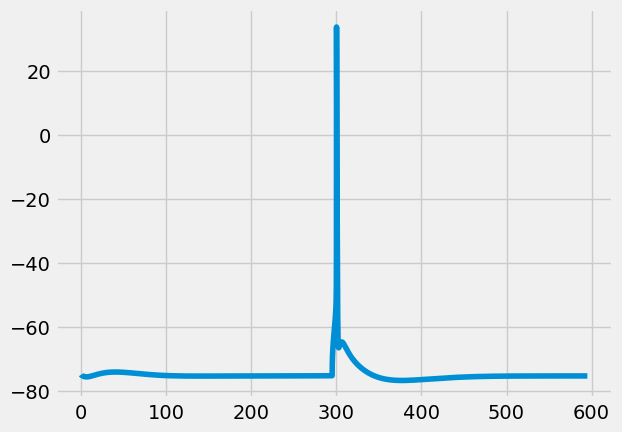

In [15]:
I.plt.style.use("fivethirtyeight")
I.plt.plot(cell.tVec, cell.sections[0].recVList[0])

#### The $BAC$ stimulus protocol

A $BAC$ stimulus is a $bAP$ stimulus, with a well-timed epsp-shaped current injection at the apical dendrite. $BAC$ here stands for $bAP$-activated $Ca^{2+}$-spike

Where exactly do we inject the epsp-shaped apical current? We already saved this information in `fixed_params`. Morphology "89" has a rather deep bifurcation, so the epsp injection is at only $295\mu m$ from the soma.

In [16]:
fixed_params['BAC.stim.dist']

294.8203371921156

In [ ]:
I.logger.setLevel("ATTENTION")
cell, p = s.get_simulated_cell(p, 'BAC')

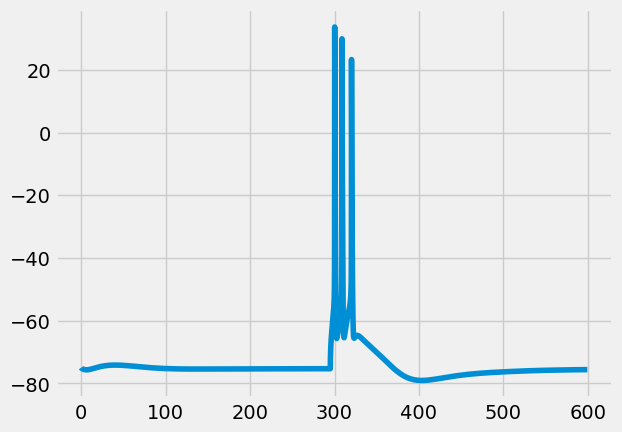

In [18]:
I.plt.plot(cell.tVec, cell.sections[0].recVList[0])

#### Running all stimulus protocols

In the previous sections, we ran an example $bAP$ stimulus, and a $BAC$ stimulus. This resulted in a single AP, and a triplet respectively. In order to verify if the biophysical properties of the cell match empirically observed responses, we also need to run $3$ step currents and measure the response.

For this, we have a Simulator that has these step currents set up:

In [19]:
s = get_Simulator(fixed_params, step=True)
s.setup.cell_param_generator = get_L5tt_template_v2
s.setup.cell_param_modify_funs.append(('scale_apical', scale_apical))

In [20]:
# may take a while, especially the step currents
voltage_traces = s.run(params=p)

These results will be convenient for [the next tutorial](./1.2%20Evaluation.ipynb). Let's save them.

In [21]:
db['simulator'] = s
db['voltage_traces'] = voltage_traces

[WARNING] isf_data_base: The database source folder has uncommitted changes!
[WARNING] isf_data_base: The database source folder has uncommitted changes!


`voltage_traces` is a dictionary with the voltage trace (i.e. NEURON's `tVec` and `vList`) of the cell for each stimulus protocol.

In [22]:
voltage_traces.keys()

dict_keys(['bAP.hay_measure', 'BAC.hay_measure', 'StepOne.hay_measure', 'StepTwo.hay_measure', 'StepThree.hay_measure'])

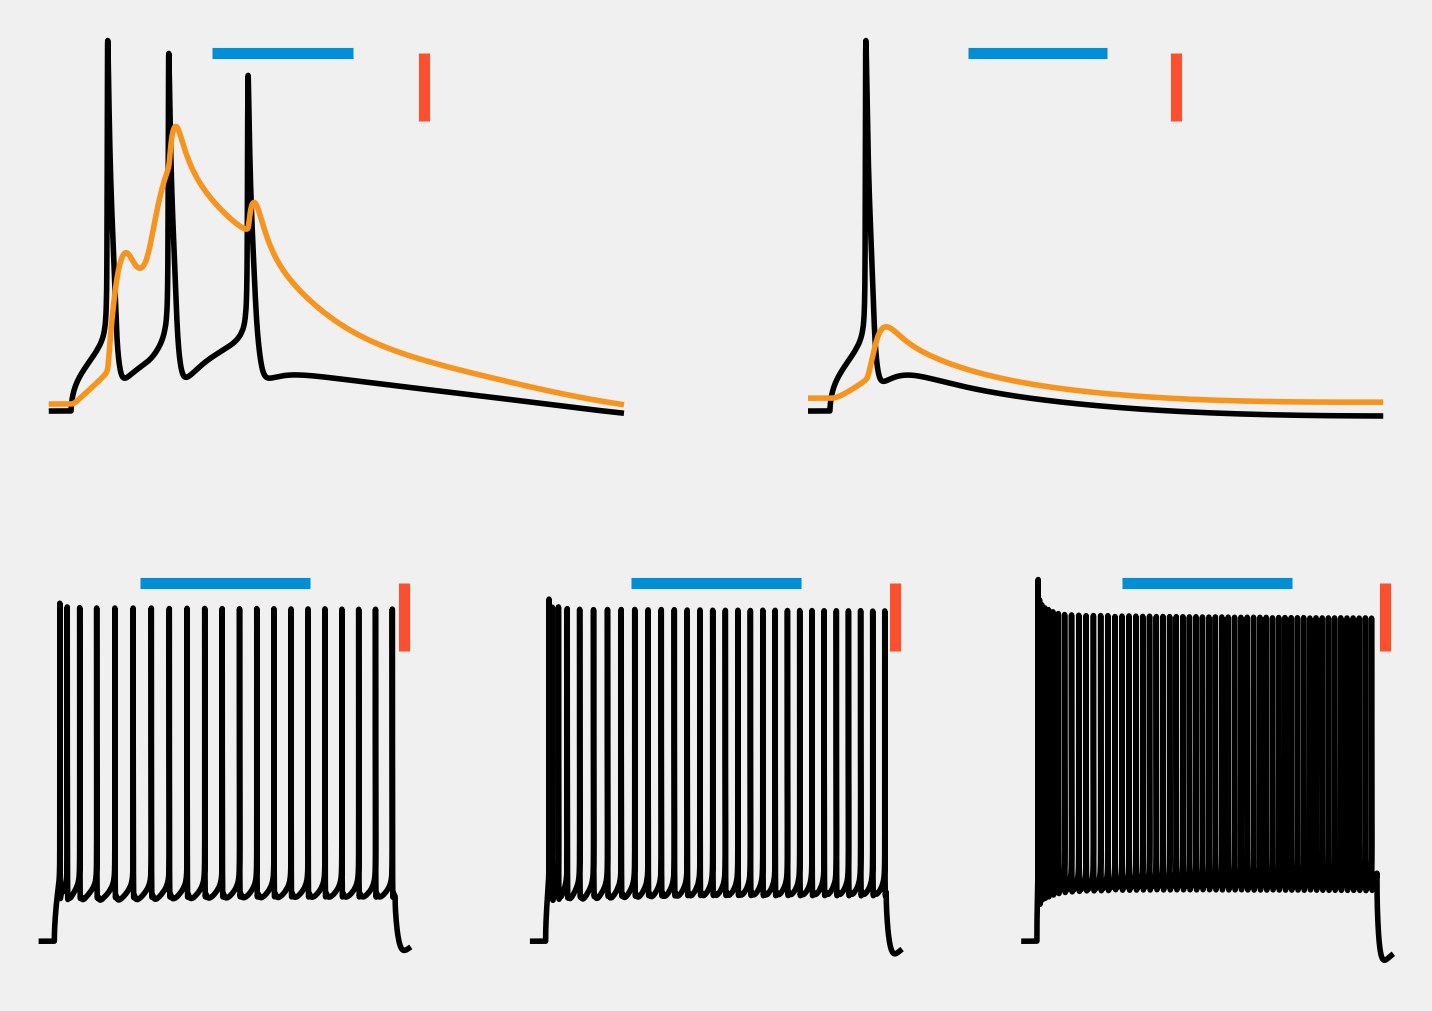

In [23]:
# visualize all responses
from visualize import voltage_trace_visualizer as vtv
vtv.visualize_vt(voltage_traces, lw=2)

## Recap

This tutorial showed how to run simulations using ISF's [`Simulator`](../../../biophysics_fitting/simulator.py).

The voltage traces of these simulations *look* good, but *looking* is not a great quantifier. Let's see how far off these responses are compared to the empirically recored ones in the next tutorial: [1.2 Evaluation](./1.2%20Evaluation.ipynb).